In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr
import xbudget
import regionate 
import xwmt
import xwmb
import xgcm
import urllib.request
import shutil
import os

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.9.0 
regionate version 0.5.3 
xwmt version 0.1.0 
xwmb version 0.5.5


In [5]:
"""
Download data from Zenodo archive
"""

file_name="SOSE_xWMB_data_Weddell_march_2013.nc"
url = 'https://zenodo.org/records/18681726/files/'
destination_path = f"../data/{file_name}"
if not os.path.exists(destination_path):
    print(f"File '{file_name}' being downloaded to {destination_path}.")
    with urllib.request.urlopen(url + file_name) as response, open(destination_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    print(f"File '{file_name}' has completed download to {destination_path}.")
else:
    print(f"File '{file_name}' already exists at {destination_path}. Skipping download.")

File 'SOSE_xWMB_data_Weddell_march_2013.nc' already exists at ../data/SOSE_xWMB_data_Weddell_march_2013.nc. Skipping download.


In [6]:
# Open data set
ds = xr.open_dataset("../data/SOSE_xWMB_data_Weddell_march_2013.nc")

In [7]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:           (time: 1, z_l: 52, yh: 289, xh: 354, time_bounds: 2,
                       xq: 355, yq: 290, z_i: 53)
Coordinates: (12/52)
  * time              (time) datetime64[ns] 8B 2013-03-16
  * z_l               (z_l) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    drF               (z_l) float32 208B ...
    rhoRef            (z_l) float32 208B ...
    maskZ             (z_l) float64 416B ...
  * yh                (yh) float32 1kB -77.98 -77.95 -77.91 ... -62.73 -62.65
    ...                ...
    geolon_c          (yq, xq) float64 824kB ...
    geolat_c          (yq, xq) float64 824kB ...
    geolon_u          (yh, xq) float64 821kB ...
    geolat_u          (yh, xq) float64 821kB ...
  * yq                (yq) float32 1kB -78.0 -77.97 -77.93 ... -62.69 -62.62
  * z_i               (z_i) float64 424B 0.0 -4.2 -9.2 ... -5.6e+03 -6e+03
Data variables: (12/28)
    oceFWflx          (time, z_l, yh, xh) float64 43MB ...
    THETA             (time, z_l, yh, xh) float32 21MB ...
    SALT              (time, z_l, yh, xh) float32 21MB ...
    SFLUX             (time, z_l, yh, xh) float64 43MB ...
    SSH_bounds        (time_bounds, yh, xh) float32 818kB ...
    THETA_bounds      (time_bounds, z_l, yh, xh) float32 43MB ...
    ...                ...
    SST               (time, yh, xh) float32 409kB ...
    SSS               (time, yh, xh) float32 409kB ...
    DELTA_ADVh_TH     (time, z_l, yh, xh) float32 21MB ...
    DELTA_DFhE_TH     (time, z_l, yh, xh) float32 21MB ...
    DELTA_ADVh_SLT    (time, z_l, yh, xh) float32 21MB ...
    DELTA_DFhE_SLT    (time, z_l, yh, xh) float32 21MB ...

In [8]:
# Create xgcm.Grid instance
coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'},
    }
boundary = {'X':'extend', 'Y':'extend', 'Z':'extend'}
metrics = {('X','Y'):'rA'}

grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata=False)

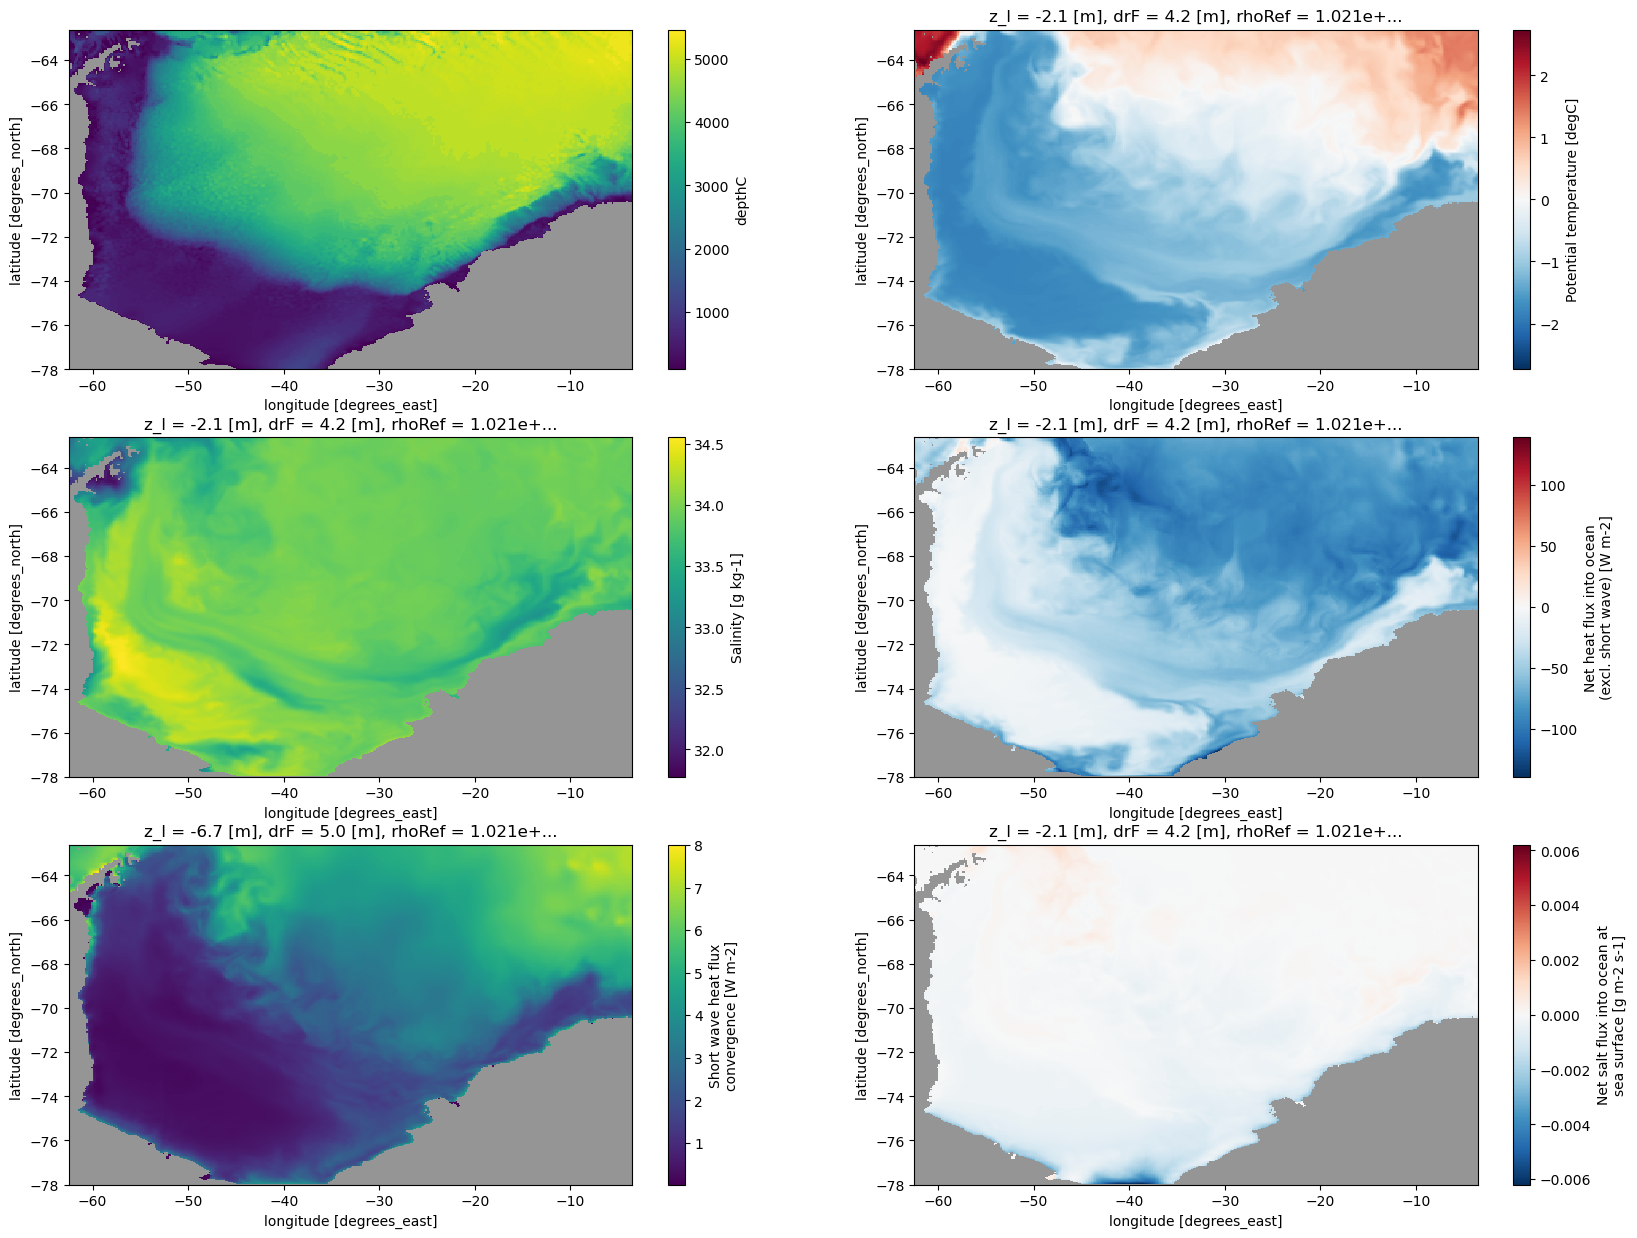

In [9]:
# plot some surface terms

fig,axs=plt.subplots(3,2,figsize=(20,15))

ds.land.plot(ax=axs[0,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.depthC.where(ds.mask2D == 0).plot(ax=axs[0,0])

ds.land.plot(ax=axs[0,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.THETA.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[0,1])

ds.land.plot(ax=axs[1,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.SALT.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[1,0])

ds.land.plot(ax=axs[1,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.TFLUXmSW.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[1,1])

ds.land.plot(ax=axs[2,0], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.SBSFQSW.isel(time=0,z_l=1).where(ds.mask2D == 0).plot(ax=axs[2,0])

ds.land.plot(ax=axs[2,1], cmap="Greys", vmin=0.5, vmax=1.5, add_colorbar=False)
ds.SFLUX.isel(time=0,z_l=0).where(ds.mask2D == 0).plot(ax=axs[2,1]);


In [10]:
# Load SOSE specific budget dictionary

import yaml
with open("./SOSE.yaml", "r") as stream:
    xbudget_dict = yaml.safe_load(stream)

In [11]:
"""
Let's look at the heat budget:
    - The two first entries describe the associated tracer, here potential temperature THETA, and corresponding surface tracer, SST.
    - The LHS is the sum of the Eulerian tendency and advection. Going further down the dictionary shows how these terms are calculated.
    - The RHS is the sum of diffusion and surface exchange flux. Again, see how these terms are computed from diagnostics, which are here upper case, by going down the dictionary.
    - The `'var': None` are there to be filled by the corresponding budget term names, as we'll see right away.
"""

xbudget_dict["heat"]

{'lambda': 'THETA',
 'surface_lambda': 'SST',
 'lhs': {'var': None,
  'sum': {'var': None,
   'Eulerian_tendency': {'var': None,
    'product': {'var': None,
     'tracer_concentration_tendency': 'TEMP_TEND',
     'specific_heat_capacity': 3992.0,
     'density': 1035.0,
     'area': 'rA',
     'thickness': 'drC'}},
   'advection': {'var': None,
    'sum': {'var': None,
     'lateral': {'var': None,
      'sum': {'var': None,
       'horizontal_heat_convergence': {'var': None,
        'product': {'var': None,
         'specific_heat_capacity': 3992.0,
         'density': 1035.0,
         'horizontal_temp_convergence': 'DELTA_ADVh_TH'}}}},
     'vertical': {'var': None,
      'sum': {'var': None,
       'vertical_heat_convergence': {'var': None,
        'product': {'var': None,
         'specific_heat_capacity': 3992.0,
         'density': 1035.0,
         'vertical_temp_convergence': 'DELTA_ADVr_TH',
         'sign': -1.0}}}}}}}},
 'rhs': {'var': None,
  'sum': {'var': None,
   'diffus

In [12]:
"""
Let's build the full budget: the `'None` are going to be replaced by the corresponding budget term names. We'll look at the heat budget to see how this is done.
"""

xbudget.collect_budgets(grid, xbudget_dict)
xbudget_dict["heat"]

{'lambda': 'THETA',
 'surface_lambda': 'SST',
 'lhs': {'var': 'heat_lhs',
  'sum': {'var': 'heat_lhs_sum',
   'Eulerian_tendency': {'var': 'heat_lhs_sum_Eulerian_tendency',
    'product': {'var': 'heat_lhs_sum_Eulerian_tendency_product',
     'tracer_concentration_tendency': 'TEMP_TEND',
     'specific_heat_capacity': 3992.0,
     'density': 1035.0,
     'area': 'rA',
     'thickness': 'drC'}},
   'advection': {'var': 'heat_lhs_sum_advection',
    'sum': {'var': 'heat_lhs_sum_advection_sum',
     'lateral': {'var': 'heat_lhs_sum_advection_sum_lateral',
      'sum': {'var': 'heat_lhs_sum_advection_sum_lateral_sum',
       'horizontal_heat_convergence': {'var': 'heat_lhs_sum_advection_sum_lateral_sum_horizontal_heat_convergence',
        'product': {'var': 'heat_lhs_sum_advection_sum_lateral_sum_horizontal_heat_convergence_product',
         'specific_heat_capacity': 3992.0,
         'density': 1035.0,
         'horizontal_temp_convergence': 'DELTA_ADVh_TH'}}}},
     'vertical': {'var': 

### Budget in density ($\sigma_2$) space

In [13]:
# specific tracer that defines the water mass
lam = "sigma2"

# Define lambda bin edges: 
# These will be: [lambda_min -dlambda/2, lambda_min + dlambda/2, ..... , lambda_max - dlambda/2, lambda_max + dlambda/2]

lambda_min = 20.0
lambda_max = 38.0
dlambda = 0.05

bins=np.arange(lambda_min-dlambda/2, lambda_max+dlambda/2, dlambda)

In [14]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Instantiate the water mass budget class
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict
    )
    
    # The domain is regional so we need to compute the horizontal transport into it.
    wmb.assert_zero_transport = False   

    # Computes the WMT terms, convergent horizontal transport, mass tendencies, close the budget.
    wmb.mass_budget(lam, greater_than=True,bins=bins)  
    
    wmt = wmb.wmt.squeeze()
    wmt.load()

In [15]:
"""
`wmt` contains all the WMT terms in sigma2 space. 

Since the dataset only contains one time step, the resulting wmt doesn't have a time dimension, 
but multiple time steps datasets are treated in a straightforward manner.
"""
wmt

<xarray.Dataset> Size: 6MB
Dimensions:                        (sigma2_l_target: 360, sigma2_i_target: 361,
                                    time_bounds: 2, yh: 289, xh: 354)
Coordinates: (12/18)
  * sigma2_l_target                (sigma2_l_target) float64 3kB 20.0 ... 37.95
  * sigma2_i_target                (sigma2_i_target) float64 3kB 19.98 ... 37.98
  * time_bounds                    (time_bounds) datetime64[ns] 16B 2013-03-0...
  * yh                             (yh) float32 1kB -77.98 -77.95 ... -62.65
  * xh                             (xh) float32 1kB -62.42 -62.25 ... -3.583
    rA                             (yh, xh) float32 409kB 0.0 0.0 ... 7.245e+07
    ...                             ...
    land                           (yh, xh) bool 102kB True True ... False False
    geolon                         (yh, xh) float64 818kB -62.42 ... -3.583
    geolat                         (yh, xh) float64 818kB -77.98 ... -62.65
    lat                            (yh, xh) float64 818kB -77.98 ... -62.65
    lon                            (yh, xh) float64 818kB -62.42 ... -3.583
    time                           datetime64[ns] 8B 2013-03-16
Data variables: (12/29)
    Eulerian_tendency_heat         (sigma2_l_target) float64 3kB 0.0 0.0 ... 0.0
    Eulerian_tendency_salt         (sigma2_l_target) float64 3kB 0.0 0.0 ... 0.0
    surface_exchange_flux_heat     (sigma2_l_target) float64 3kB 0.0 0.0 ... 0.0
    surface_exchange_flux_salt     (sigma2_l_target) float64 3kB 0.0 0.0 ... 0.0
    advection_heat                 (sigma2_l_target) float64 3kB 0.0 0.0 ... 0.0
    advection_salt                 (sigma2_l_target) float64 3kB 0.0 0.0 ... 0.0
    ...                             ...
    mass_tendency                  (sigma2_l_target) float64 3kB 0.007111 ......
    dt                             float64 8B 2.592e+06
    realized_transformation        (sigma2_l_target) float64 3kB 1.941e+08 .....
    spurious_numerical_mixing      (sigma2_l_target) float64 3kB 1.941e+08 .....
    advection_plus_BC              (sigma2_l_target) float64 3kB -0.0 ... -0.0
    diabatic_advection             (sigma2_l_target) float64 3kB 1.941e+08 .....

#### Plot water mass budget in density space

The water mass budget, for the considered Weddell gyre region, in density coordinates, and for waters denser ($\geq$) than $\sigma_2$ is given by:
\begin{equation}
\partial_{t} \mathcal{M}_{\geq}(\sigma_2) = \Psi_{\geq}(\sigma_2) + \mathcal{G}^{(BF)}_{\geq}(\sigma_2) + \mathcal{G}^{(Mix)}_{\geq}(\sigma_2) + \mathcal{G}^{(Spu)}_{\geq}(\sigma_2) + \mathcal{S}_{\geq}(\sigma_2),
\end{equation}
where:
- $\partial_{t} \mathcal{M}_{\geq}(\sigma_{2}, t)$ quantifies the rate of change of waters denser than $\sigma_{2}$

- $\Psi_{\geq}$ quantifies the rate at which waters denser than $\sigma_{2}$ enter the region through its borders (interior horizontal circulation)

- $\mathcal{G}^{(BF)}_{\geq}$ quantifies the rate at which waters lighter than $\sigma_{2}$ transform into waters denser than $\sigma_{2}$ due to surface buoyancy fluxes (via heat, salt, or freshwater fluxes)

- $\mathcal{G}^{(Mix)}_{\geq}$ quantifies the rate at which waters lighter than $\sigma_{2}$ transform into waters denser than $\sigma_{2}$ due to mixing processes (e.g. explicit diffusion of heat and salt)

- $\mathcal{G}^{(Spu)}_{\geq}$ quantifies the rate at which waters lighter than $\sigma_{2}$ transform into waters denser than $\sigma_{2}$ due to spurious numerical mixing. **Note:** This term cannot be explicitly computed and is thus indirectly inferred from the residual of all the other terms in the budget.

- $\mathcal{S}_{\geq}$ quantifies the rate at which surface freshwater fluxes add mass directly to a water mass. **Note:** This term is generally small and distinct from the effect that freshwater fluxes have on salinity (and hence density), which is instead included in $\mathcal{G}^{(BF)}_{\geq}$.



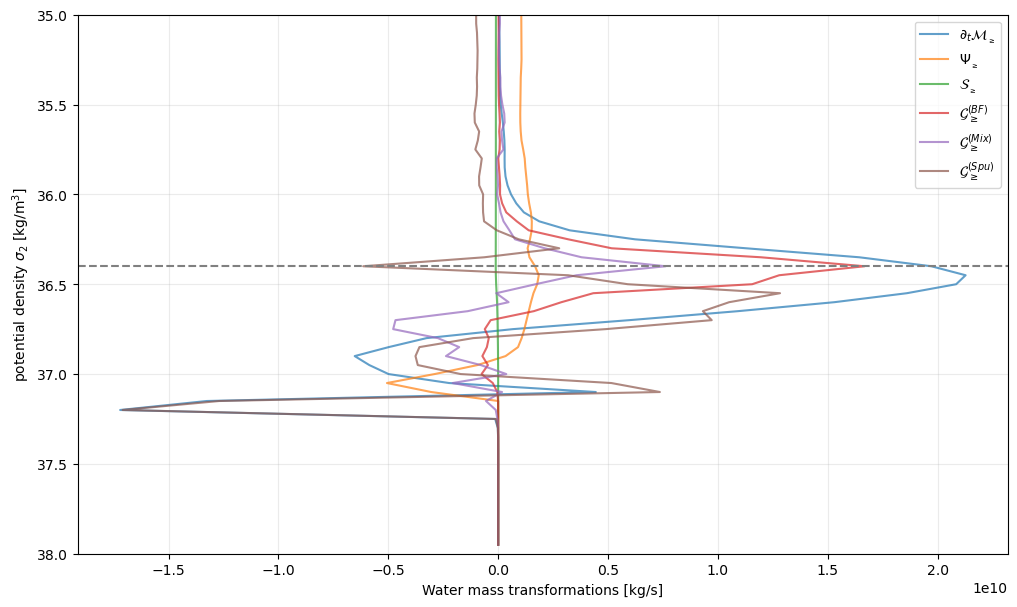

In [16]:
plt.figure(figsize=(12,7))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot( wmt.mass_tendency,                wmt.sigma2_l_target, label=r"$\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( wmt.convergent_mass_transport,    wmt.sigma2_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.sigma2_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.sigma2_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
plt.axhline(36.4, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(38, 35);

#### Interpretation

Consider the mass budget for $\sigma_{2} = 36.4$ $\text{kg/m}^{3}$, highlighted by the dashed grey line in the figure above:

- Dense waters enter the region through its interior boundaries at a rate of $\Psi_{\geq} \simeq 0.2 \times 10^{10}$ kg/s.

- Surface buoyancy loss, presumably from sensible heat flux lost to the cold atmosphere, form dense waters at a rate of $\mathcal{G}^{(BF)}_{\geq} \simeq 1.6 \times 10^{10}$ kg/s.

- Interior mixing by various parameterized physical processes creates dense waters at a rate of $\mathcal{G}^{(Mix)}_{\geq} \simeq 0.75 \times 10^{10}$ kg/s.

- Direct addition of fresh water at the surface $\mathcal{S}_{\geq}$ is negligible.

- Spurious numerical mixing associated with errors in the horizontal advection scheme or vertical advection scheme induce water mass transformations that are generally weaker than those due to parameterized mixing, but are not always of the same sign! Here spurious mixing acts in the opposite way of explicit mixing by destroying dense waters at a rate of $\mathcal{G}^{(Spu)}_{\geq} = -0.6 \times 10^{10}$ kg/s.

- The large contribution of surface buoyancy loss is the main factor resulting in an imbalance that causes the mass of dense water to increase at a mean rate of $\partial_{t} \mathcal{M}_{\geq} \simeq 1.9 \times 10^{10}$ kg/s $\simeq 18$ Sv over the course of March 2013.

Other remarks:

- $\Psi_{\geq}$ switches from negative values at the densest density classes to negative values at lighter density classes. This points to meridional overturning happening in the Weddell gyre, which is an important site bottom water formation.

- The explicit mixing contribution also reverses sign. This points to the fact that denser waters are destroyed by mixing with lighter waters; in this process, intermediate density waters are thus created (aas the aforementioned positive value of $\mathcal{G}^{(Mix)}_{\geq}$ indicates.

### Further refining the analysis: the `decompose` functionality

In the above watermass budget, the `boundary_fluxes` term is equal to the `surface_exchange_flux` term (because there is no other boundary flux) which is itself the sum of `surface_exchange_flux_salt` and `surface_exchange_flux_heat` (which you can verify by summing these terms), and we don't have access to the further separation of the latter in short wave and non-short wave heat fluxes.

To obtain this information, we need to decompose it into its summed constituents.
To achieve that, we need to tell `xwmb` to decompose the `surface_exchange_term`.

Let's recompute the budget, but this time decomposing this term.

In [17]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Instantiate the water mass budget class
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict,
        decompose=["surface_exchange_flux"] # Tell xWMB to explicitly decompose this term into its summed components 
    )                                                    #   !!! This must be a list !!!
    wmb.assert_zero_transport = False

    wmb.mass_budget(lam, greater_than=True,bins=bins)
    wmt = wmb.wmt.squeeze()
    wmt.load()

In [18]:
# We can check that new terms have been computed

wmt

<xarray.Dataset> Size: 6MB
Dimensions:                                    (sigma2_l_target: 360,
                                                sigma2_i_target: 361,
                                                time_bounds: 2, yh: 289, xh: 354)
Coordinates: (12/18)
  * sigma2_l_target                            (sigma2_l_target) float64 3kB ...
  * sigma2_i_target                            (sigma2_i_target) float64 3kB ...
  * time_bounds                                (time_bounds) datetime64[ns] 16B ...
  * yh                                         (yh) float32 1kB -77.98 ... -6...
  * xh                                         (xh) float32 1kB -62.42 ... -3...
    rA                                         (yh, xh) float32 409kB 0.0 ......
    ...                                         ...
    land                                       (yh, xh) bool 102kB True ... F...
    geolon                                     (yh, xh) float64 818kB -62.42 ...
    geolat                                     (yh, xh) float64 818kB -77.98 ...
    lat                                        (yh, xh) float64 818kB -77.98 ...
    lon                                        (yh, xh) float64 818kB -62.42 ...
    time                                       datetime64[ns] 8B 2013-03-16
Data variables: (12/32)
    surface_exchange_flux_non_short_wave_heat  (sigma2_l_target) float64 3kB ...
    surface_exchange_flux_salt_flux_salt       (sigma2_l_target) float64 3kB ...
    advection_heat                             (sigma2_l_target) float64 3kB ...
    advection_salt                             (sigma2_l_target) float64 3kB ...
    Eulerian_tendency_heat                     (sigma2_l_target) float64 3kB ...
    Eulerian_tendency_salt                     (sigma2_l_target) float64 3kB ...
    ...                                         ...
    mass_tendency                              (sigma2_l_target) float64 3kB ...
    dt                                         float64 8B 2.592e+06
    realized_transformation                    (sigma2_l_target) float64 3kB ...
    spurious_numerical_mixing                  (sigma2_l_target) float64 3kB ...
    advection_plus_BC                          (sigma2_l_target) float64 3kB ...
    diabatic_advection                         (sigma2_l_target) float64 3kB ...

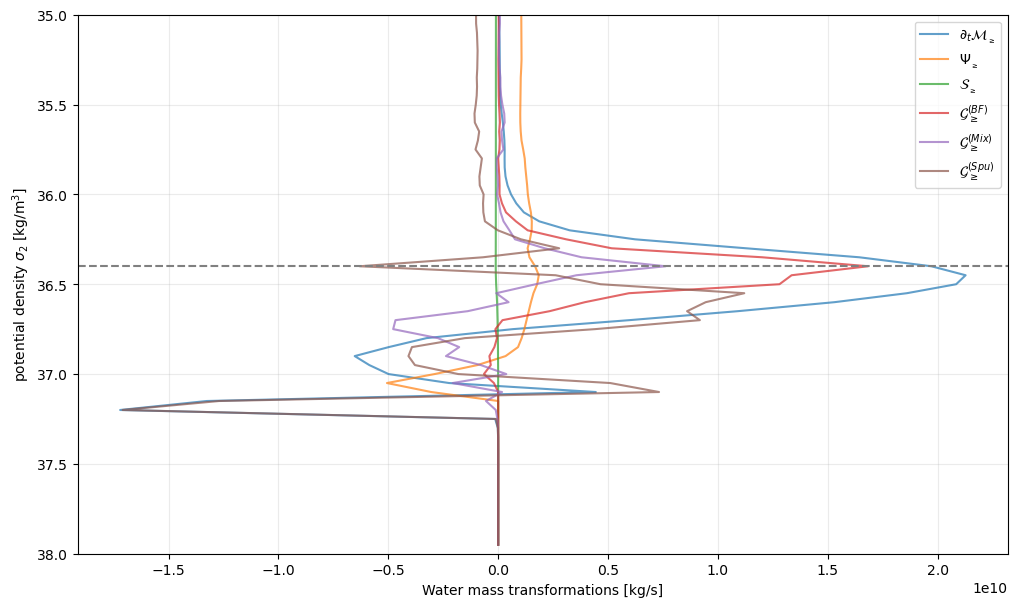

In [19]:
# We can check that the budget didn't change

plt.figure(figsize=(12,7))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot( wmt.mass_tendency,                wmt.sigma2_l_target, label=r"$\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( wmt.convergent_mass_transport,    wmt.sigma2_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.sigma2_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.sigma2_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
plt.axhline(36.4, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(38, 35);

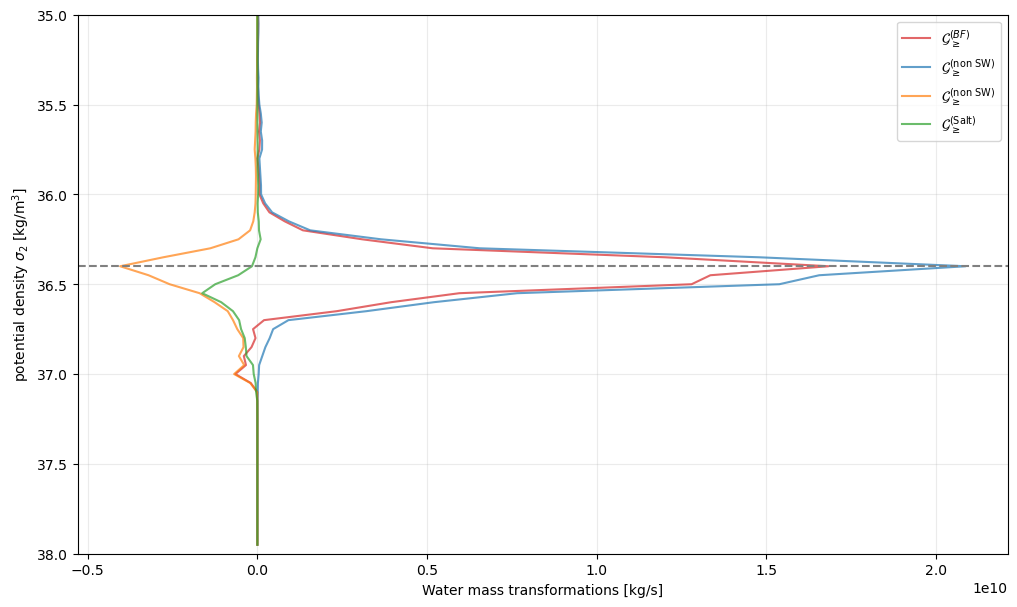

In [20]:
# Let's look at the decomposition of the boundary fluxes:

plt.figure(figsize=(12,7))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot( wmt.boundary_fluxes, wmt.sigma2_l_target, color="tab:red", label=r"$\mathcal{G}^{(BF)}_{\geq}$",**kwargs)
plt.plot( wmt.surface_exchange_flux_non_short_wave_heat, wmt.sigma2_l_target, label=r"$\mathcal{G}^{(\text{non SW})}_{\geq}$",**kwargs)
plt.plot( wmt.surface_exchange_flux_short_wave_heat, wmt.sigma2_l_target, label=r"$\mathcal{G}^{(\text{non SW})}_{\geq}$",**kwargs)
plt.plot( wmt.surface_exchange_flux_salt_flux, wmt.sigma2_l_target, label=r"$\mathcal{G}^{(\text{Salt})}_{\geq}$",**kwargs)

plt.axhline(36.4, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(38, 35);

Decomposing the surface forcing contribution shows the non-SW negative heat flux (buoyancy loss = densification) being weakly mitigated by solar heating (which always acts to lighten water masses), and also a small negative contribution from surface salt flux (salt removal = water mass lightening)

### Budget in temperature space

In [21]:
# specific tracer that defines the water mass
lam = "heat"

# Define lambda bin edges: 
# These will be: [lambda_min -dlambda/2, lambda_min + dlambda/2, ..... , lambda_max - dlambda/2, lambda_max + dlambda/2]

lambda_min = -3.
lambda_max = 5.
dlambda = 0.1

bins=np.arange(lambda_min-dlambda/2., lambda_max+dlambda/2, dlambda)

In [22]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Instantiate the water mass budget class
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict
    )
    wmb.assert_zero_transport = False

    wmb.mass_budget(lam, greater_than=False,bins=bins)
    wmt = wmb.wmt.squeeze()
    wmt.load()

#### Plot water mass budget in (potential) temperature space

Here, we consider the budget in temperature space, and for waters colder ($\leq$) than $\theta$:
\begin{equation}
\partial_{t} \mathcal{M}_{\leq}(\theta) = \Psi_{\leq}(\theta) + \mathcal{G}^{(BF)}_{\leq}(\theta) + \mathcal{G}^{(Mix)}_{\leq}(\theta) + \mathcal{G}^{(Spu)}_{\leq}(\theta) + \mathcal{S}_{\leq}(\theta).
\end{equation}
Switching to a $\leq$-budget in temperature space should lead to comparable results with the $\geq$-budget in density space, as low values of temperature broadly correspond to high values of density and vice-versa.
The terms in the budget should now be interpreted as:
- $\partial_{t} \mathcal{M}_{\leq}(\theta, t)$ quantifies the rate of change of waters colder than $\theta$

- $\Psi_{\leq}$ quantifies the rate at which waters colder than $\theta$ enter the region through its borders (interior horizontal circulation)

- $\mathcal{G}^{(BF)}_{\leq}$ quantifies the rate at which waters warmer than $\theta$ transform into waters colder than $\theta$ due to surface buoyancy fluxes (via heat fluxes)

- $\mathcal{G}^{(Mix)}_{\leq}$ quantifies the rate at which waters warmer than $\theta$ transform into waters colder than $\theta$ due to mixing processes (e.g. explicit diffusion of heat)

- $\mathcal{G}^{(Spu)}_{\leq}$ quantifies the rate at which waters warmer than $\theta$ transform into waters colder than $\theta$ due to spurious numerical mixing. **Note:** This term cannot be explicitly computed and is thus indirectly inferred from the residual of all the other terms in the budget.

- $\mathcal{S}_{\leq}$ quantifies the rate at which surface freshwater fluxes add mass directly to a water mass. **Note:** This term is generally small and distinct from the effect that freshwater fluxes have on salinity (and hence density), which is instead included in $\mathcal{G}^{(BF)}_{\leq}$.



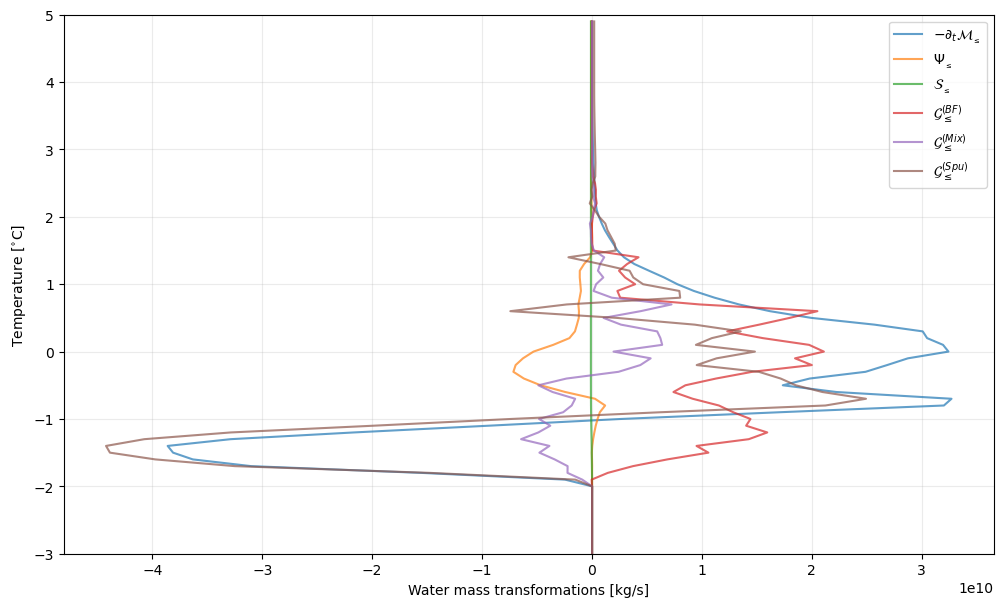

In [23]:
plt.figure(figsize=(12,7))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot( wmt.mass_tendency,                wmt.THETA_l_target, label=r"$-\partial_{t} \mathcal{M}_{_{\leq}}$",**kwargs)
plt.plot( wmt.convergent_mass_transport,    wmt.THETA_l_target, label=r"$\Psi_{_{\leq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.THETA_l_target, label=r"$\mathcal{S}_{_{\leq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.THETA_l_target, label=r"$\mathcal{G}^{(BF)}_{\leq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.THETA_l_target, label=r"$\mathcal{G}^{(Mix)}_{\leq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.THETA_l_target, label=r"$\mathcal{G}^{(Spu)}_{\leq}$", **kwargs)
plt.axhline(34, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"Temperature [$^{\circ}$C]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(-3.,5.);

### Possible investigation:

- Plot the WMT budget in salinity space (`lam="salt"`) and compare with the previously computed budgets.
- Download the January dataset (see next cell) and compare the WMT budgets with those obtained for the March dataset. Visualize surface values of the different terms to understand these changes.  

In [24]:
# Download data from Zenodo archive

file_name="SOSE_xWMB_data_Weddell_january_2013.nc"
url = 'https://zenodo.org/records/18681726/files/'
destination_path = f"../data/{file_name}"
if not os.path.exists(destination_path):
    print(f"File '{file_name}' being downloaded to {destination_path}.")
    with urllib.request.urlopen(url + file_name) as response, open(destination_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    print(f"File '{file_name}' has completed download to {destination_path}.")
else:
    print(f"File '{file_name}' already exists at {destination_path}. Skipping download.")

File 'SOSE_xWMB_data_Weddell_january_2013.nc' already exists at ../data/SOSE_xWMB_data_Weddell_january_2013.nc. Skipping download.
